In [1]:
from yfmf import *
import os
from os import walk
from os import path
import tensorflow as tf
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy as scp
from math import erf
import yfinance as yf
import collections
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from datetime import date
from itertools import cycle, islice
from sklearn.preprocessing import MinMaxScaler
import mplfinance as mpf
import copy

C:\Users\salmasi\.conda\envs\tensorflow2\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
f = []
for (dirpath, dirnames, filenames) in walk("data\\"):
    f.extend(filenames)
    break
tickers= [x.replace('.csv', '') for x in filenames]

In [3]:
'''read data from csv file'''
dfs={}
dates_pdtimestamp={}
date_index_str_split={}

for ticker in tickers:
    try:
        path.exists("data\\"+ticker+".csv")
        dfs[ticker]=pd.read_csv("data\\"+ticker+".csv",index_col=0,parse_dates=True)
        dates_pdtimestamp[ticker]=dfs[ticker].index
        date_index_str=(dfs[ticker].index.astype(str))
        splits=[]
        for string in date_index_str:
            splits.append(string.split('-'))
        Y,D,M=[],[],[]
        for split in splits:
            Y.append(int(split[0]))
            M.append(int(split[1]))
            D.append(int(split[2]))
        dfs[ticker]['Y'],dfs[ticker]['M'],dfs[ticker]['D']=Y,M,D
        dfs[ticker].index=np.arange(0,len(dfs[ticker]),1)
    except OSError as e:
        print("Error: %s : %s" % ("data\\"+ticker+".csv", e.strerror))
dfs['aapl'].head()


,Open,High,Low,Close,Adj Close,Volume,Y,M,D
0,30.447144,30.478571,30.080000,30.104286,26.061205,88102700,2009,12,31
1,30.490000,30.642857,30.340000,30.572857,26.466835,123432400,2010,1,4
2,30.657143,30.798571,30.464285,30.625713,26.512596,150476200,2010,1,5
3,30.625713,30.747143,30.107143,30.138571,26.090879,138040000,2010,1,6
4,30.250000,30.285715,29.864286,30.082857,26.042646,119282800,2010,1,7


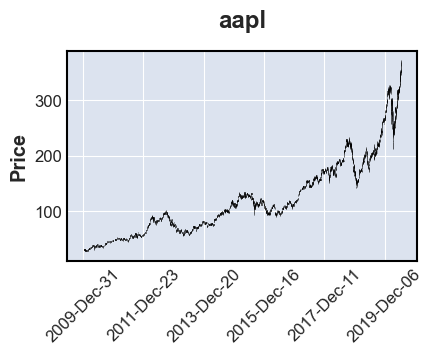

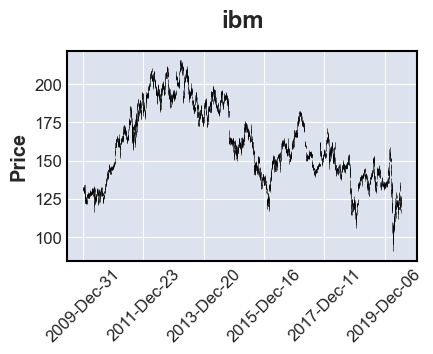

In [4]:
'''plot'''
lim1=0
lim2=-1
means=()
for ticker in tickers:
    data = pd.read_csv("data\\"+ticker+".csv",index_col=0,parse_dates=True)
    plot_stocks(data,lim1,lim2,means,ticker,frmaesize=(5,3),show_nonetrading=False,show_volume=False)

In [5]:
'''scale values'''
target={}
dfs_sc= copy.deepcopy(dfs)
for ticker in tickers:
    for col in dfs[ticker].keys():
        if col!='D' and col!='Y' and col!='M' and col!='Adj Close':
            dfs_sc[ticker][col] = MinMaxScaler().fit_transform(dfs_sc[ticker][[col]])
    #plot_features(dfs[ticker],dfs_sc[ticker])
    target[ticker]= dfs_sc[ticker].pop('Adj Close')
dfs_sc['aapl'].head()

,Open,High,Low,Close,Volume,Y,M,D
0,0.008787,0.007197,0.008659,0.007870,0.167232,2009,12,31
1,0.008914,0.007674,0.009435,0.009252,0.244222,2010,1,4
2,0.009409,0.008126,0.009805,0.009407,0.303155,2010,1,5
3,0.009316,0.007977,0.008740,0.007971,0.276055,2010,1,6
4,0.008203,0.006637,0.008015,0.007807,0.235179,2010,1,7


In [36]:
'''slice trainsets'''
train_sets={}
dev_sets={}
test_sets={}
train,dev,test,ltrain,ldev,ltest =split_data(dfs_sc['ibm'],target['ibm'],0.9,0.05)
train_shuffle= train.shuffle(ltrain).batch(2**8)
dev_shuffle= dev.shuffle(ldev).batch(16)
test_shuffle= test.shuffle(ltest).batch(16)

Features: [3.13048544e-01 2.97139552e-01 3.24793928e-01 2.98520989e-01
 1.03436506e-01 2.00900000e+03 1.20000000e+01 3.10000000e+01], Target: 93.61602783203124
Features: [3.02864649e-01 2.98155082e-01 3.25602123e-01 3.11327756e-01
 1.69377961e-01 2.01000000e+03 1.00000000e+00 4.00000000e+00], Target: 94.72455596923828
Features: [3.07004407e-01 2.88676450e-01 3.19541028e-01 2.98107970e-01
 1.92796581e-01 2.01000000e+03 1.00000000e+00 5.00000000e+00], Target: 93.58028411865234
Features: [2.98724891e-01 2.85629729e-01 3.17197335e-01 2.91084867e-01
 1.50604836e-01 2.01000000e+03 1.00000000e+00 6.00000000e+00], Target: 92.97238159179688
Features: [2.92018503e-01 2.75135437e-01 3.09924070e-01 2.87366806e-01
 1.58636320e-01 2.01000000e+03 1.00000000e+00 7.00000000e+00], Target: 92.6505355834961
2639 2375 131 133


In [37]:
for elements,_ in train_shuffle.take(1):  # only take first element of dataset
    numpy_elements = elements.numpy()
    input_size = (numpy_elements.size)
model = get_compiled_model(input_size)

In [38]:
fit= model.fit(train_shuffle, epochs=50)

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 63ms/step - loss: -627821.6875 - accuracy: 0.0000e+00
Epoch 2/50
10/10 [==============================] - 1s 59ms/step - loss: -3365712.2500 - accuracy: 0.0000e+00
Epoch 3/50
10/10 [==============================] - 1s 59ms/step - loss: -9747786.0000 - accuracy: 0.0000e+00
Epoch 4/50
10/10 [==============================] - 1s 59ms/step - loss: -22670568.0000 - accuracy: 0.0000e+00
Epoch 5/50
10/10 [==============================] - 1s 60ms/step - l

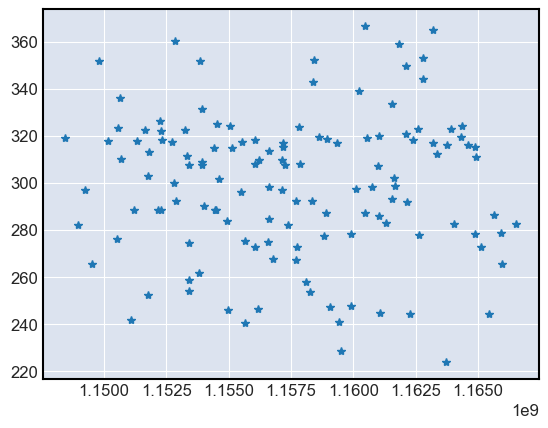

In [39]:
predictions = model.predict(dev_shuffle)
plt.plot(predictions,target['aapl'][-ldev:],'*')


In [10]:
# holdDays = 5
# totalDays = dfs_concat_scaled_dataframe.shape[0]
# #mlpr.fit(dfs_concat_scaled_dataframe.index[0:(totalDays-holdDays)].T, dfs_concat_scaled_dataframe['Adj Close'][0:(totalDays-holdDays)])
# mlpr.fit(a, dfs_concat_scaled_dataframe['Adj Close'][0:(totalDays-holdDays)])

In [11]:
# #Predict the stock price using the model
# pricePredict = mlpr.predict(date_idx)
# #Display the predicted reuslts agains the actual data
# plt.plot(date_idx, adj_close_price)
# plt.plot(date_idx, pricePredict, c='#5aa9ab')
# plt.show()

In [12]:
# #Number of neurons in the input, output, and hidden layers
# input2 = 1
# output2 = 1
# hidden2 = 50
# #array of layers, 3 hidden and 1 output, along with the tanh activation function 
# layers = [('F', hidden2), ('AF', 'tanh'), ('F', hidden2), ('AF', 'tanh'), ('F', hidden2), ('AF', 'tanh'), ('F', output2)]
# #construct the model and dictate params
# mlpr2 = ANNR([input2], layers, batchSize = 256, maxIter = 10000, tol = 0.01, reg = 1e-4, verbose = True)

In [13]:
# holdDays = 5
# totalDays = len(date_idx)
# mlpr2.fit(date_idx[0:(totalDays-holdDays)], adj_close_price[0:(totalDays-holdDays)])
# pricePredict2 = mlpr2.predict(date_idx)

In [14]:
# plt.plot(date_idx, adj_close_price)
# plt.plot(date_idx, pricePredict, c='#5aa9ab')
# plt.plot(date_idx, pricePredict2, c='#8B008B')
# plt.show()

In [15]:
# pricePredict3 = mlpr2.predict(date_idx[-holdDays:])
# print((pricePredict3-date_idx[-holdDays:])/date_idx[-holdDays:]*100)